In [75]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import model_selection

pd.options.display.float_format = '{:40,.4f}'.format
plt.style.use('ggplot')
%matplotlib inline

# Predicting building demolition risk in Philadelphia's residential neighbourhoods, 2018-2021
## Introduction

Increasing demand for urban amenities in Philadelphia has put a growing proportion of the city’s buildings at risk of demolition. Between 2009 and 2019, the number of demolition permits issued to private developers increased by 255%, overtaking the number of City-mandated demolition permits — which target neglected structures — in 2018 (Briggs, 2019). Several of these permits have been issued for historic and cultural landmarks, enabled by Philadelphia’s lack of protection for historic buildings (Blumgart, 2019; Maule, 2019; Saffron, 2021). In addition, private demolitions are concentrated in gentrifying neighbourhoods (Blumgart, 2018), further reducing affordable housing stock and thus increasing the displacement risk of original residents (Charles, 2013). 

To protect Philadelphia’s historic fabric and affordable housing supply, planners and preservation advocates need to anticipate which buildings are likely to be demolished in the coming years. While building-level models of demolition risk have been developed for other cities (Weber et al., 2006; Dye and McMillen, 2007; Charles, 2012; Dubé et al., 2018), none have been developed for Philadelphia, which may have different determinants of demolition. In addition, these studies use logistic regression to model the probability of demolition, which are limited in their ability to take interactions between predictors into account. 

Using open property data from the City of Philadelphia and U.S. Census data, this report builds on these research gaps. A logistic regression model is constructed to identify possible determinants of demolition risk in the city, the performance of which is then compared to that of a Random Forest (RF) classification algorithm. The aims of this report are twofold: to explain potential factors of demolition risk in Philadelphia, and to identify which approach policymakers should take to predict building demolition risk. 

## Literature Review

### Predictors of demolition risk

Building demolition is a response to rent gaps: situations where the value of a property (plus the cost of its demolition) is worth less than the land on which it is located (Smith, 1979; Munneke, 1996). As such, the demolition risk for individual properties is linked to both characteristics of properties themselves and characteristics of their surrounding neighbourhoods. Building features associated with low property values and neighbourhood features associated with high or increasing property values increase the risk of building demolition (Weber et al., 2006; Dye and McMillen, 2007; Charles, 2012). Characteristics relevant to building features are listed in Table 1:

In [2]:
#Table of building characteristics

### Methods for modelling demolition risk

Existing studies of building demolition risk in cities focus on _explaining_ the determinants of demolition risk rather than _predicting_ which buildings are at risk of demolition (Weber et al., 2006; Dye and McMillen, 2007; Charles, 2013). These studies thus employ logistic regression to model demolition risk, allowing researchers and policymakers to directly quantify the potential impacts of property and neighbourhood characteristics. While the interpretability of logistic regression models lends them explanatory utility, these models cannot fully account for the interactions between property and neighbourhood characteristics, possibly reducing their predictive power (Reades et al., 2018). 

Machine-learning classification approaches, such as the RF algorithm used in this study, offer a potential solution. RF algorithms construct multiple decision trees, each of which identifies a different chain of rules for classifying observations, based on combinations of features. The final classification of an observation is a majority “vote” by all trees. With the use of rules for classifying observations, a decision-tree method accounts for collinearity and interactions between variables, which Weber et al. (2006) suggested might exist among the determinants of demolition risk. Therefore, while RF classification may be less interpretable to policymakers, its predictive power may be higher. 

## Research Question

**How can planners predict the demolition risk of individual buildings in Philadelphia?**


## Presentation of Data
### Data collection
Data on demolitions, property-level, and neighbourhood-level characteristics was collected from various local and federal government sources. Given the large number of properties included in the dataset (over 500,000) and the number of features attached to each property (42), executing the code for data collection takes a considerable amount of time. This section therefore omits the full code, instead outlining the data collection process in detail. The code described in this section can be found in a separate notebook on [Github](https://github.com/caranvr/DSSS-predicting-demolition/blob/main/data-collection-code.ipynb).

#### Demolitions

The City of Philadelphia's Licenses and Inspections Department maintains a database of all demolition permits in the city issued since 2007. The addresses associated with private demolition permits from 2018-2021 were extracted, as public demolitions are more reflective of structural issues than consumer demand (Weber et al., 2006). 

#### Property characteristics

The City of Philadelphia's Office of Property Assessments (OPA) maintains a regularly updated, georeferenced database of city properties, which contains building characteristics used to assess property tax rates. Due to the large size of the dataset, this database was accessed through an API call. Based on property characteristics found to predict demolition risk in previous studies, the following (non-identifying) features were selected:
- **interior_condition**: a numeric code representing the quality of a property's interior. Properties are rated on a scale of 1 to 7, with 1 corresponding to new construction and 7 corresponding to "structurally compromised" (City of Philadelphia, 2021). A value of 0 indicates vacant land. 
- **exterior_condition**: a numeric code representing the property's external appearance, using the same scale as *interior_condition*. 
- **total_area**: the total area of the property.
- **year_built**: the year the property was built.

To match properties to Census tracts and find distances to relevant attractions, the latitude and longitude of each property were requested as well. In addition, **category_code_description** was selected, as Weber et al. (2006) only looked at single-family residential property demolition. Commercial, industrial, or multi-family residential properties may have different predictors of demolition risk. 

The most comprehensive property dataset is the most recent one. However, for 86.3% of properties with an associated demolition permit, the property assessment on file is from prior to demolition, or the building has not yet been demolished. The remaining properties have been re-assessed since their demolition and are now listed as vacant land. Since the model includes building characteristics, and these features are null for properties classed as 'Vacant Land', all properties in this category were dropped from the dataset. The remaining properties were matched against the demolition dataset to identify whether or not a demolition permit was attached to them after 2018. 

A separate OPA dataset was used to find each property's market value in 2018, then joined to the main properties dataset. 

#### Distance attributes

In line with Ding and Hwang (2016), City Hall was used as a proxy for the city centre. The geopandas library was used to calculate the distance from each property to City Hall. 

Finding the distance from each property to its closest public transport stop was more involved, as there is no single shapefile of all public transport stops in the city. Therefore, shapefiles of commuter rail, subway, and trolley stops were downloaded and concatenated into one dataframe. This dataframe was then converted into a binary search tree using scipy's cKDTree method, which allowed for quick spatial querying.

#### Neighbourhood attributes

Due to data availability, neighbourhoods were defined as U.S. Census tracts, which have an average population of 4,000 residents (Weber et al., 2006; Oka and Wong, 2016). The U.S. Census American Community Survey (ACS) 2013-18 5-Year Estimates were used for 2018 demographic variables, while the Longitudinal Tract Database (LTDB) — which matches 2000 Census data to post-2010 Census tract boundaries (Logan et al., 2014) — was used for the same variables in 2000. 

For comparison to the LTDB variables, ACS columns related to higher education were summed. This was done during the data collection process to reduce the size of the full dataset. Properties were then spatially matched to Census tracts using the geopandas library. 

### Data cleaning

In [3]:
#Load in processed dataset in chunks to save memory
chunks = []
chunked_df = pd.read_csv('geo_props_final.csv', chunksize=40000)

for chunk in chunked_df:
    chunks.append(chunk)

df = pd.concat(chunks)

In [4]:
df.set_index('parcel_number', inplace=True)
df.head()

,lng,lat,location,category_code_description,interior_condition,exterior_condition,total_area,year_built,demolition,market_value,...,POP00,NHWHT00,NHBLK00,HISP00,HU00,OWN00,RENT00,AG25UP00,COL00,HINC00
parcel_number,,,,,,,,,,,,,,,,,,,,,
11001660,-75.148540,39.931445,222 WHARTON ST,Single Family,4.0,4.0,1622.70,1960,0,212700.0,...,3715.000108,1958.888794,809.169495,331.332611,1700.323242,808.19928,635.013733,2356.681885,317.74942,36532.250861
11001670,-75.148604,39.931452,224 WHARTON ST,Single Family,4.0,4.0,1624.50,1960,0,212800.0,...,3715.000108,1958.888794,809.169495,331.332611,1700.323242,808.19928,635.013733,2356.681885,317.74942,36532.250861
11001680,-75.148668,39.931463,226 WHARTON ST,Single Family,4.0,4.0,1627.20,1960,0,212800.0,...,3715.000108,1958.888794,809.169495,331.332611,1700.323242,808.19928,635.013733,2356.681885,317.74942,36532.250861
11001690,-75.148729,39.931470,228 WHARTON ST,Single Family,4.0,4.0,1683.90,1960,0,215000.0,...,3715.000108,1958.888794,809.169495,331.332611,1700.323242,808.19928,635.013733,2356.681885,317.74942,36532.250861
11003500,-75.147067,39.930988,108 SEARS ST,Single Family,4.0,4.0,426.56,1920,0,140800.0,...,3715.000108,1958.888794,809.169495,331.332611,1700.323242,808.19928,635.013733,2356.681885,317.74942,36532.250861


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534304 entries, 11001660 to 882150800
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   lng                        534304 non-null  float64
 1   lat                        534304 non-null  float64
 2   location                   534304 non-null  object 
 3   category_code_description  534304 non-null  object 
 4   interior_condition         533936 non-null  float64
 5   exterior_condition         534253 non-null  float64
 6   total_area                 534304 non-null  float64
 7   year_built                 534304 non-null  int64  
 8   demolition                 534304 non-null  int64  
 9   market_value               532712 non-null  float64
 10  geometry                   534304 non-null  object 
 11  dist_city_hall             534304 non-null  float64
 12  dist_to_transport          534304 non-null  float64
 13  index_right        

Columns from the 2013-18 ACS were renamed for easier interpretation.

In [6]:
df.rename(columns={
    'B01001_001E': 'POP18',
    'B03002_003E': 'NHWHT18',
    'B03002_004E': 'NHBLK18',
    'B03001_003E': 'HISP18',
    'B25003_001E': 'HU18',
    'B25003_002E': 'OWN18',
    'B25003_003E': 'RENT18',
    'B15002_001E': 'AG25UP18',
    'B19013_001E': 'HINC18'
}, inplace=True)

Features that are on an ordinal scale were converted to category data types for later one-hot encoding. 

In [7]:
cat_cols = ['category_code_description', 'interior_condition', 'exterior_condition']

for c in cat_cols:
    if c == 'category_code_description':
        df[c] = df[c].astype('category')
    else:
        df[c] = df[c].astype(pd.UInt16Dtype()).astype('category')

Columns were then inspected for null values, which are not accepted in the classification methods used for this analysis.

In [8]:
#Check for columns where most values are null
total = df.isnull().sum().sort_values(ascending=False)
percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[:5]

,Total,Percent
market_value,1592,0.297958
interior_condition,368,0.068875
HINC18,71,0.013288
exterior_condition,51,0.009545
HINC00,0,0.000000


Only four columns have missing data, and the percentage of rows in each column with missing values is small. Missing values can therefore be dropped or imputed without a significant impact on model bias.

Given that interior_condition and exterior_condition are ordinal scales, the only option for imputing missing values in these columns is mode imputation. Mode imputation for these features may be inaccurate for individual properties, even if modal values from the same Census tract rather than the whole city were used, as buildings can vary significantly even within neighbourhoods. Thus, properties with missing values for these columns were dropped.

In [9]:
missing_bldgs = df.loc[
    (df['interior_condition'].isnull()) |
    (df['exterior_condition'].isnull())
]

print(f'{missing_bldgs.shape[0]} properties will be dropped')

370 properties will be dropped


In [10]:
df.drop(index=missing_bldgs.index, inplace=True)

The 2018 market value of an individual property _is_ related to the market value of neighbouring properties. Therefore, null values could be imputed with the median value of properties in the same Census tract. However, market value is also a function of property-level characteristics, which would not be taken into consideration during imputation. Properties with missing market values were thus dropped.

In [11]:
missing_values = df.loc[
    df['market_value'].isnull()
]

print(f'{missing_values.shape[0]} properties will be dropped')

1523 properties will be dropped


In [12]:
df.drop(index=missing_values.index, inplace=True)

The properties missing a Census tract median income for 2018 were all in one of two Census tracts, meaning that two Census tracts were missing 2013-18 median income data:

In [13]:
pd.DataFrame(df.loc[
    df['HINC18'].isnull()
].groupby('TRACTCE10').size().sort_values(ascending=False)).rename(columns={0: 'Missing values'})

,Missing values
TRACTCE10,
989100,39
980100,32


Given that only 71 properties were affected and in two Census tracts, missing values were imputed with the median income in Philadelphia. 

In [14]:
df['HINC18'] = df['HINC18'].fillna(df['HINC18'].median())

The dataset was then checked for invalid values in the 'year_built' column. Properties with a value of 0 in this column were dropped.    

In [15]:
missing_years = df.loc[
    df['year_built'] == 0
]

print(f'{missing_years.shape[0]} properties will be dropped')

1731 properties will be dropped


In [16]:
df.drop(index=missing_years.index, inplace=True)

Lastly, columns that represent total populations and housing units for Census tracts were checked for zeroes, as counts of population grorups and housing unit types were later converted to percentages. Total counts of zero would result in null values, so properties in these Census tracts had to be dropped. 

In [17]:
zero_totals = df.loc[
    (df['HU00'] == 0) |
    (df['HU18'] == 0) |
    (df['POP00'] == 0) |
    (df['POP18'] == 0)
]

print(f'{zero_totals.shape[0]} properties will be dropped')

38 properties will be dropped


In [18]:
df.drop(index=zero_totals.index, inplace=True)

In [19]:
df.shape

(530642, 36)

#### Feature transformation

For comparability between Census tracts, raw counts of residents or households in each demographic group were converted to percentages of a total, either of residents or housing units. (In line with U.S. Census practices, the number of residents with a Bachelor's degree or above was calculated as the proportion of residents _over 25_ with a Bachelor's degree or above.) 

In [20]:
#Convert selected features to percentages
def convert_to_pc(df, cols, denominator):
    for c in cols:
        df[c] = (df[c]/df[denominator])*100
    return df

pc_cols = {
    'POP00': ['NHWHT00', 'NHBLK00', 'HISP00'], #key is denominator, value is list of columns to divide by denominator
    'HU00': ['OWN00', 'RENT00'],
    'AG25UP00': ['COL00'],
    'POP18': ['NHWHT18', 'NHBLK18', 'HISP18'],
    'HU18': ['OWN18', 'RENT18'],
    'AG25UP18': ['COL18']
}

for k,v in pc_cols.items():
    df = convert_to_pc(df,v,k)

To measure change in neighbourhood characteristics, columns corresponding to 2000 were converted to the percentage point difference (for percentage columns) or percentage change (for total columns) in tract values from 2000 to 2018.

In [21]:
#Convert 2000 columns to percentage change from 2000-2018

#Lookup for fields encoding percentage point difference from 2000 to 2018
pc_diff = {
    'NHWHT18': 'NHWHT00',
    'NHBLK18': 'NHBLK00',
    'HISP18': 'HISP00',
    'OWN18': 'OWN00',
    'RENT18': 'RENT00',
    'COL18': 'COL00'
}

#Lookup for fields encoding percentage point change from 2000 to 2018 (counts)
pc_change = {
    'POP18': 'POP00', #total population
    'HU18': 'HU00', #total housing units
    'AG25UP18': 'AG25UP00', #25+ population
    'HINC18': 'HINC00' #median household income
}

#Replace 2000 columns with the percentage change or difference from 2000 to 2018
for k,v in pc_diff.items():
    df[v] = df[k] - df[v]

for k,v in pc_change.items():
    df[v] = ((df[k] - df[v])/df[v])*100

For interpretability purposes, the 'year_built' column was converted so that it would represent the age of a building in 2018.

In [22]:
df['year_built'] = 2018 - df['year_built']

Finally, to enable classification, categorical features were converted into dummy variables. 

In [23]:
id_cols = ['lng', 'lat', 'geometry', 'location', 'index_right', 'TRACTCE10', 'NAME10']
var_cols = [c for c in df.columns.values if c not in id_cols]

df_var = df[var_cols].copy()
df_var = pd.get_dummies(df_var)

### Exploratory data analysis


To determine which classification approach would be appropriate, the class balance of the dataset — the proportion of properties with an associated demolition permit — was examined.

In [24]:
df_var.groupby('demolition').size()

demolition
0    529786
1       856
dtype: int64

The vast majority (99.84%) of properties in Philadelphia did not have an associated demolition permit from after 2018, a heavy imbalance that would lead to poor classification of demolitions. Common approaches to such an imbalance include undersampling the majority class or oversampling the minority class (Ruiz-Gazen and Villa, 2008). However, artificially balancing the dataset can lead to suboptimal model performance on real-world, class-imbalanceed data. 

Thus, to balance out the dataset, only properties in Census tracts with high demolition rates were included in the analysis. This way, the algorithm would be trained on neighbourhoods that face higher overall demolition risk — where predictive analytics would be most useful — but the class balance would even out slightly. For simplicity, the upper quartile of demolition counts per tract was calculated, and properties in Census tracts with demolition counts above this cutoff were included.

In [25]:
#Going back to original df with identifiers
df.rename(columns={'index_right': 'census_tract'}, inplace=True)
demolitions_by_tract = pd.DataFrame(df.groupby(['census_tract', 'demolition']).size()).rename(columns={0: 'Properties'})

In [32]:
demolitions_by_tract.xs(1, level='demolition').describe().rename(columns={'Properties': 'Demolitions'})

,Demolitions
count,198.000000
mean,4.323232
std,5.325598
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,29.000000


In [33]:
#Find tracts with high numbers of demolitions
high_dem_tracts = demolitions_by_tract.xs(1, level='demolition').loc[
    demolitions_by_tract.xs(1, level='demolition')['Properties'] >= 6
].index.values

#Isolate df_var to only parcels in high-demolition tracts
high_dem_parcels = df.loc[df['census_tract'].isin(high_dem_tracts)].index

df_var = df_var.loc[high_dem_parcels]

In [34]:
df_var.shape

(71820, 47)

In [35]:
df_var.groupby('demolition').size()

demolition
0    71233
1      587
dtype: int64

A slightly higher proportion of properties in the filtered dataset have associated demolition permits than in the full dataset (0.8% vs. 0.16%). However, the class imbalance is still extreme, and therefore still needs to be accounted for in the classification process.

### Summary statistics

A basic logistic regression model could not include all predictors; as shown in Figure 1, there is a high degree of multicollinearity between features, especially between neighbourhood characteristics. 

Text(0.5, 1.0, 'Correlation Heatmap')

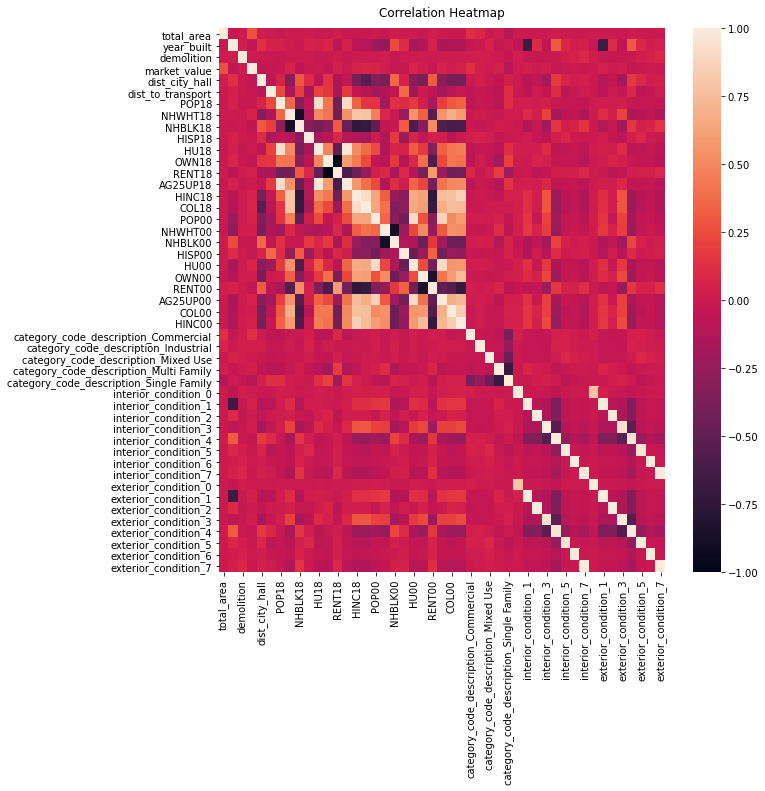

In [43]:
#Correlation matrix
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(df_var.corr(), vmin=-1, vmax=1)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

<AxesSubplot:ylabel='Frequency'>

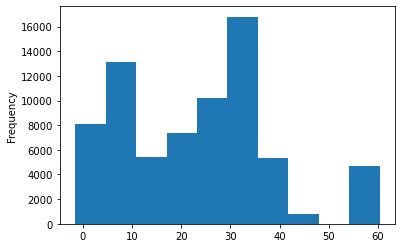

In [50]:
#Histograms of continuous variables
df_var['COL00'].plot.hist(bins=10)

## Methodology

A PCR model and an RF model were constructed, then compared on how well they predicted demolition. To aid in model estimation and validation, the dataset was split into predictors and labels. 

In [52]:
X = df_var.drop(columns='demolition')
Y = df_var['demolition']

### Principal component logistic regression

To account for multicollinearity between features while preserving the information they contain, continuous features were transformed into principal components, which were then used as inputs to a logistic regression model to predict demolition. 

In [72]:
#Isolate continous variables
categoricals = [c for c in X.columns.values if re.search('category_code_description|interior_condition|exterior_condition', c)]
X_pc = X.drop(columns=categoricals).values

#Rescale continuous variables
X_pc = StandardScaler().fit_transform(X_pc)

#Find components
pca = PCA(random_state=51)
# fit the components
X_new_components = pca.fit_transform(X_pc)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[3.67731928e-01 1.50796852e-01 9.06477302e-02 6.93822307e-02
 5.06952909e-02 4.59218610e-02 3.95184309e-02 3.49644438e-02
 3.24263354e-02 2.90656709e-02 2.49347026e-02 1.88385676e-02
 1.69177963e-02 7.96014891e-03 5.31484988e-03 4.52636084e-03
 3.21588467e-03 2.09632974e-03 1.83978007e-03 1.41203009e-03
 8.28375834e-04 4.82619658e-04 2.88780380e-04 1.92999318e-04
 1.11470081e-31]


<AxesSubplot:xlabel='PC'>

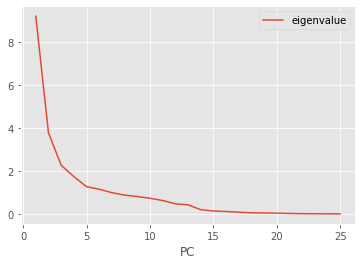

In [76]:
pca_df = pd.DataFrame({'eigenvalue':pca.explained_variance_, 'PC':list(range(1, pca.n_components_ + 1))})
pca_df.plot.line(x = 'PC', y = 'eigenvalue')

The eigenvalue of each principal component indicates how much variance the component explains. To find the correct number of principal components to use in the regression model, the 'knee' in the scree plot above was chosen: in this case, five components were retained.

In [77]:
#Extract five components
X_pc_results = X_pc[:,[0,1,2,3,4]]

Then, to avoid the dummy variable trap, one level was dropped from each categorical variable.

In [27]:
#Drop one level for each dummy variable


Index(['total_area', 'year_built', 'market_value', 'dist_city_hall',
       'dist_to_transport', 'POP18', 'NHWHT18', 'NHBLK18', 'HISP18', 'HU18',
       'OWN18', 'RENT18', 'AG25UP18', 'HINC18', 'COL18', 'POP00', 'NHWHT00',
       'NHBLK00', 'HISP00', 'HU00', 'OWN00', 'RENT00', 'AG25UP00', 'COL00',
       'HINC00', 'category_code_description_Commercial',
       'category_code_description_Industrial',
       'category_code_description_Mixed Use',
       'category_code_description_Multi Family',
       'category_code_description_Single Family', 'interior_condition_0',
       'interior_condition_1', 'interior_condition_2', 'interior_condition_3',
       'interior_condition_4', 'interior_condition_5', 'interior_condition_6',
       'interior_condition_7', 'exterior_condition_0', 'exterior_condition_1',
       'exterior_condition_2', 'exterior_condition_3', 'exterior_condition_4',
       'exterior_condition_5', 'exterior_condition_6', 'exterior_condition_7'],
      dtype='object')

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_test, Y_test, random_state=51)

In [33]:
X_dev, X_test, Y_dev, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=51)

In [35]:
tree = DecisionTreeClassifier()
%timeit tree.fit(X_train, Y_train)

9.42 s ± 1.14 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
tree.score(X_test, Y_test)

0.9969395908398788

In [37]:
dt_pred = tree.predict(X_test)

In [49]:
print(classification_report(Y_test, dt_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66227
           1       0.08      0.09      0.08       104

    accuracy                           1.00     66331
   macro avg       0.54      0.54      0.54     66331
weighted avg       1.00      1.00      1.00     66331



In [47]:
confusion_matrix(Y_test, dt_pred)

array([[66119,   108],
       [   95,     9]])

### Random Forest classifier

In [50]:
# number of trees to tune
no_trees = [10,20,30,40,50,70,100,150,200]

# process of tune the number of trees
max_score = 0
best_no_trees = None
for t in no_trees:
    m = RandomForestClassifier(n_estimators=t, class_weight='balanced').fit(X_train, Y_train)
    score = m.score(X_dev, Y_dev)
    if score > max_score:
        max_score = score
        best_no_trees = t

In [51]:
max_score

0.9981607115935475

In [52]:
best_no_trees

70

In [53]:
rf=RandomForestClassifier(n_estimators=best_no_trees, class_weight='balanced')
rf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=70)

In [54]:
rf.score(X_test, Y_test)

0.9984019538375721

In [55]:
rf_pred = rf.predict(X_test)

In [56]:
print(classification_report(Y_test, rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66227
           1       0.33      0.02      0.04       104

    accuracy                           1.00     66331
   macro avg       0.67      0.51      0.52     66331
weighted avg       1.00      1.00      1.00     66331



In [27]:
#Write function to tune hyperparameters for each classifier with GridSearchCV
def tune_hyperparameters(parameters, classifier, X, Y):
    '''parameters: a dictionary with the parameter to be tuned and the values to test
       classifier: the classifier method to tune
       X: training set of predictors
       Y: training set of dependent variables'''
    
    clf = model_selection.GridSearchCV(classifier, parameters, n_jobs=-1)

    clf.fit(X, Y)

    print ("The best parameter value is: ")
    print (clf.best_params_)
    print ("The best score is: ")
    print (clf.best_score_)

In [ ]:
#Tune hyperparameters using GridSearchCV

In [ ]:
#Fit classifier

## Results and Discussion

In [ ]:
#Metrics for each classifier (table)

In [ ]:
#Confusion matrix for each classifier (figure)

In [ ]:
#Map of false positives for each classifier

In [ ]:
#Map of false negatives for each classifier

## Conclusion

## References